In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


# Preprocessing the Data for a Neural Network

In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=["EIN", "NAME"], axis=1)
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [4]:
inc_amt_counts = application_df.INCOME_AMT.value_counts()
inc_amt_counts

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

# 1. Check ASK_AMT and bin values if necessary

In [5]:
# Look at ASK_AMT value counts for binning
ask_amt_counts = application_df.ASK_AMT.value_counts()
ask_amt_counts

5000       25398
10478          3
15583          3
6725           3
63981          3
           ...  
772556         1
70103          1
27096          1
25049          1
1138700        1
Name: ASK_AMT, Length: 8747, dtype: int64

<AxesSubplot:ylabel='Density'>

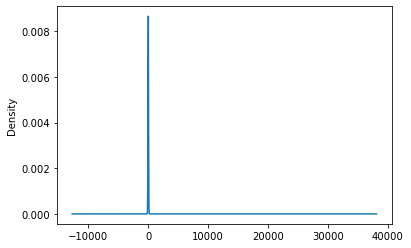

In [6]:
# Visualize the value counts of ASK_AMT
ask_amt_counts.plot.density()

### The graph shows that there are many points with very ask amount

In [7]:
# Determine which values to replace if counts are less than ...?
replace_ask_amt = list(ask_amt_counts[ask_amt_counts < 1000].index)

# Replace in dataframe
for amt in replace_ask_amt:
    if amt <= 49999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("5001-49999"))
    elif amt < 99999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("50000-99999"))
    elif amt < 499999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("100000-499999"))
    elif amt < 999999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("500000-999999"))
    elif amt < 4999999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("1M-5M"))
    else:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("5M+"))
    
application_df.ASK_AMT = application_df.ASK_AMT.astype(str)

# Check to make sure binning was successful
application_df.ASK_AMT.value_counts()

# By binning - you can see that there are 25,398 records with ask_amt of less than 5,000

5000             25398
5001-49999        2947
100000-499999     2305
50000-99999       1421
1M-5M              940
500000-999999      651
5M+                637
Name: ASK_AMT, dtype: int64

In [8]:
# Look at APPLICATION_TYPE value counts for binning
application_counts = application_df.APPLICATION_TYPE.value_counts()
application_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T15        2
T29        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

# 2. Check APPLICATION_TYPE and bin values if necessary

<AxesSubplot:ylabel='Density'>

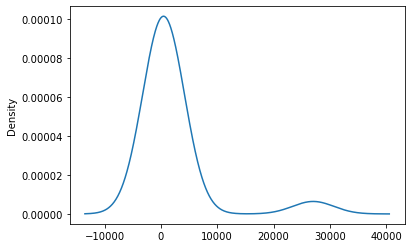

In [9]:
# Visualize the value counts of APPLICATION_TYPE
application_counts.plot.density()

In [10]:
# Determine which values to replace if counts are less than ...?
replace_application = list(application_counts[application_counts < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()



T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

# 3. Check CLASSIFICATION_TYPE and bin values if necessary

In [13]:
classification_counts = application_df.CLASSIFICATION.value_counts()
classification_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C5200        1
C6100        1
C2600        1
C1580        1
C1900        1
Name: CLASSIFICATION, Length: 71, dtype: int64

In [14]:
# Determine which values to replace if counts are less than ..?
replace_class = list(classification_counts[classification_counts < 1000].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

<AxesSubplot:ylabel='Density'>

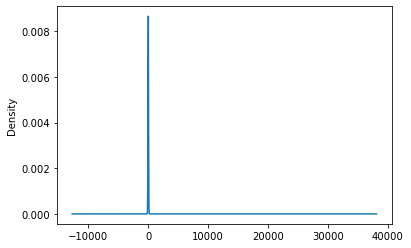

In [15]:
# Visualize the value counts of ASK_AMT
ask_amt_counts.plot.density()

In [16]:
# Determine which values to replace if counts are less than ...?
replace_ask_amt = list(ask_amt_counts[ask_amt_counts < 1000].index)

# Replace in dataframe
for amt in replace_ask_amt:
    if amt <= 49999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("5001-49999"))
    elif amt < 99999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("50000-99999"))
    elif amt < 499999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("100000-499999"))
    elif amt < 999999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("500000-999999"))
    elif amt < 4999999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("1M-5M"))
    else:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("5M+"))
    
application_df.ASK_AMT = application_df.ASK_AMT.astype(str)

# Check to make sure binning was successful
application_df.ASK_AMT.value_counts()

5000             25398
5001-49999        2947
100000-499999     2305
50000-99999       1421
1M-5M              940
500000-999999      651
5M+                637
Name: ASK_AMT, dtype: int64

# 4. Check APPLICATION_TYPE and bin values if necessary

In [18]:
# Look at APPLICATION_TYPE value counts for binning
application_counts = application_df.APPLICATION_TYPE.value_counts()
application_counts

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

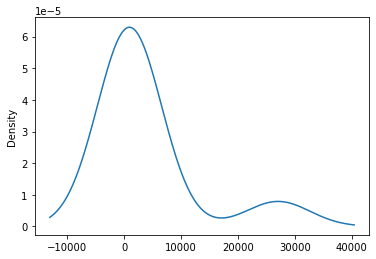

In [19]:
# Visualize the value counts of APPLICATION_TYPE
application_counts.plot.density()

In [20]:
# Determine which values to replace if counts are less than ...?
replace_application = list(application_counts[application_counts < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()



T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [22]:
# Generate Lists

In [23]:
# Generate our categorical variable lists
application_cat = ["APPLICATION_TYPE", "AFFILIATION", "CLASSIFICATION", "USE_CASE", "ORGANIZATION", "INCOME_AMT", 
                  "SPECIAL_CONSIDERATIONS", "ASK_AMT"]

Create One-Hot Encoder

In [25]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ASK_AMT_100000-499999,ASK_AMT_1M-5M,ASK_AMT_5000,ASK_AMT_50000-99999,ASK_AMT_500000-999999,ASK_AMT_5001-49999,ASK_AMT_5M+
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True, right_index=True).drop(columns=application_cat, axis=1)
application_df.head()

,STATUS,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ASK_AMT_100000-499999,ASK_AMT_1M-5M,ASK_AMT_5000,ASK_AMT_50000-99999,ASK_AMT_500000-999999,ASK_AMT_5001-49999,ASK_AMT_5M+
0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Split the Database into training and testing

In [27]:
# Split our preprocessed data into our features and target arrays
y = application_df.IS_SUCCESSFUL
X = application_df.drop("IS_SUCCESSFUL", axis=1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [28]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Adding more neurons to a hidden layer

In [29]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
nodes_hidden_layer1 = 100
nodes_hidden_layer2 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer1, activation="relu", input_dim=number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               5000      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 8,061
Trainable params: 8,061
Non-trainable params: 0
_________________________________________________________________
